### Relevante pakker

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

Merk: ChatGPT har blitt brukt for å få hjelp til å skrive deler av denne koden.

### Rense dataene

In [157]:
df = pd.read_csv("lego.population.csv", sep = ",", encoding = "latin1")
import pandas as pd

# Clean the 'Theme' column, remove special characters
df['Theme'] = df['Theme'].astype(str)
df['Theme'] = df['Theme'].str.replace(r'[^a-zA-Z0-9\s-]', '', regex=True)

# Clean the 'Price' column
df['Price'] = df['Price'].str.replace('\$', '', regex = True)

# Filter out and drop rows where 'Theme' is 'DUPLO'
#df = df[df['Theme'] != 'DUPLO']

# Filter out and drop rows with certain 'Ages' values
df = df[df['Ages'] != 'Ages_NA']
df = df[df['Ages'] != 'NaN']

# Remove any leading/trailing whitespace from "Ages", and then remove 1 1/2 from Ages
df['Ages'] = df['Ages'].str.strip()
df = df[df['Ages'] != 'Ages_1½']  

# Trim Ages enstries to only keep numbers
df['Ages'] = df['Ages'].str.replace('Ages_', '').str.replace('+', '').str.replace('-.*', '')

# Convert age strings to int
df['Ages'] = pd.to_numeric(df['Ages'], errors='coerce').fillna(0).astype(int)

# Drop every age less than 3 years old
df = df[df['Ages'] > 3]

df

array([ 6,  4,  5,  7, 10,  8,  9, 12, 18, 16, 11, 14])

In [143]:
# fjerner forklaringsvariabler vi ikke trenger
df2 = df[['Pieces', 'Pages', 'Ages']]

# fjerner observasjoner med manglende datapunkter
df2 = df2.dropna()

df2

,Pieces,Pages,Ages
2,52.0,37.0,4
3,60.0,37.0,4
13,95.0,40.0,6
14,1.0,1.0,4
16,69.0,28.0,4
...,...,...,...
1173,3178.0,452.0,16
1174,3120.0,464.0,16
1175,1105.0,556.0,10
1176,3662.0,564.0,18


### Mer eller mindre relevante kodesnutter

In [144]:
print(df2.mean(numeric_only = True))

Pieces    456.211876
Pages     105.423752
Ages        7.639676
dtype: float64


In [145]:
print(df2['Ages'].value_counts())

Ages
6     167
7     136
8     107
10     88
5      79
4      55
9      45
16     27
12     16
18     12
11      5
14      4
Name: count, dtype: int64


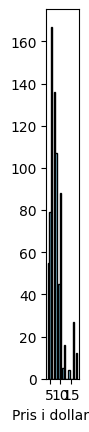

In [146]:
plt.hist(df2['Ages'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Pris i dollar [$]')
plt.ylabel('')
plt.gca().set_aspect(1)
plt.show()

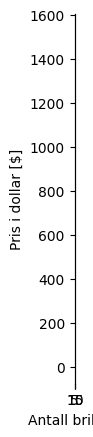

In [147]:
plt.scatter(df2['Ages'], df2['Pages'])
plt.xlabel('Antall brikker')
plt.ylabel('Pris i dollar [$]')
plt.gca().set_aspect(5)
plt.show()

In [148]:
# hva er det dyreste settet i datasettet mon tro?
print(df2.loc[df2['Ages'].idxmax()])

Pieces    625.0
Pages     116.0
Ages       18.0
Name: 556, dtype: float64


In [149]:
# og hvilket har flest brikker?
print(df2.loc[df2['Pieces'].idxmax()])

Pieces    6020.0
Pages      636.0
Ages        16.0
Name: 821, dtype: float64


In [150]:
# hvilke tema har de billigste settene?
df2.groupby('Ages')['Pieces'].mean().sort_values(ascending=True)[:3]

Ages
5    137.291139
4    172.400000
6    187.497006
Name: Pieces, dtype: float64

In [151]:
# hvilke tema har flest brikker?
df2.groupby('Ages')['Pieces'].mean().sort_values(ascending=False)[:3]

Ages
11    2454.800000
16    2340.370370
18    1627.166667
Name: Pieces, dtype: float64

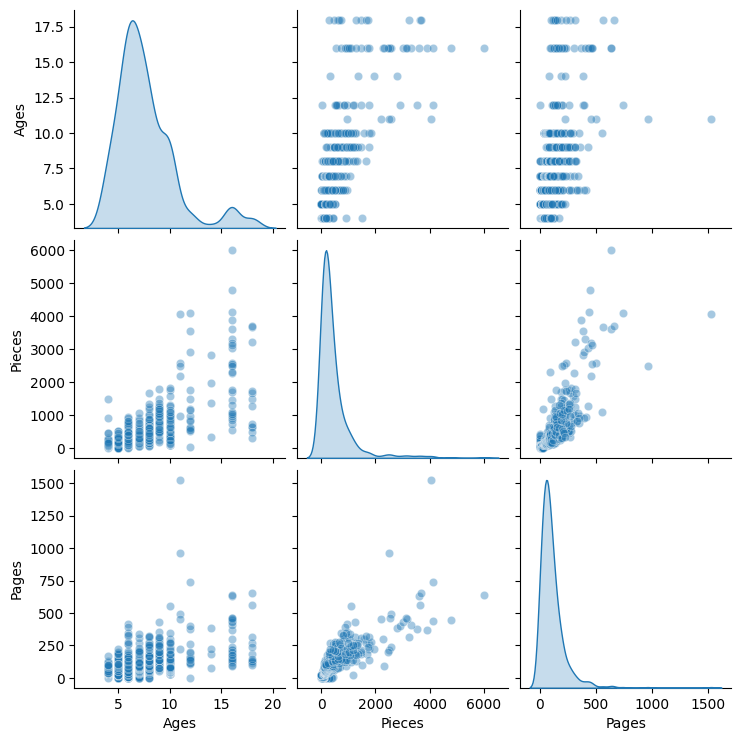

In [152]:
sns.pairplot(df2, vars = ['Ages', 'Pieces', 'Pages'],
             diag_kind = 'kde',
             plot_kws = dict(alpha = 0.4))
plt.show()

In [161]:
# enkel lineær regresjon
formel = 'Pages ~ Pieces'

modell = smf.ols(formel, data = df2)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Pages   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     1468.
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          9.43e-178
Time:                        11:54:28   Log-Likelihood:                -4170.2
No. Observations:                 741   AIC:                             8344.
Df Residuals:                     739   BIC:                             8354.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.8847      3.009     13.257      0.000      33.978      45.791
Pieces         0.1437      0.004     38.316      0.000       0.136       0.151
==============================================================================
Omnibus:                      742.228   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            86467.841
Skew:                           4.210   Prob(JB):                         0.00
Kurtosis:                      55.246   Cond. No.                         975.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

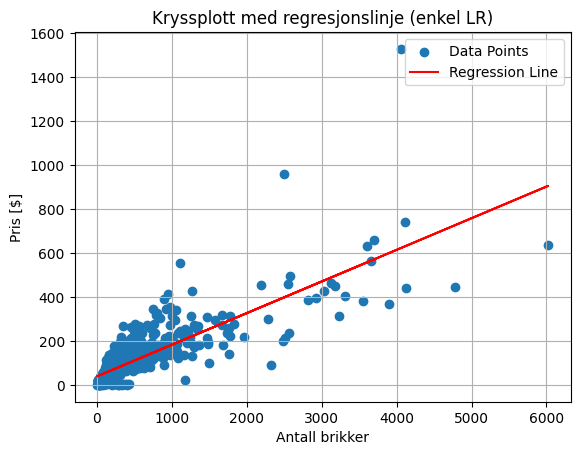

In [162]:
slope = resultat.params['Pieces']
intercept = resultat.params['Intercept']

regression_x = np.array(df2['Pieces'])

regression_y = slope * regression_x + intercept

plt.scatter(df2['Pieces'], df2['Pages'], label='Data Points')
plt.plot(regression_x, regression_y, color='red', label='Regression Line')
plt.xlabel('Antall brikker')
plt.ylabel('Pris [$]')
plt.title('Kryssplott med regresjonslinje (enkel LR)')
plt.legend()
plt.grid()
plt.show()

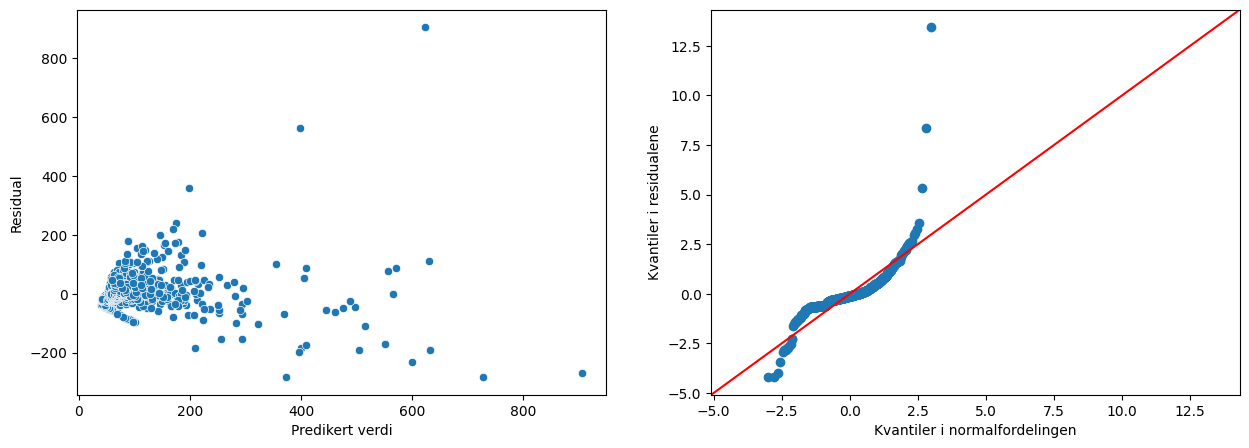

In [163]:
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = resultat.fittedvalues, y = resultat.resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")

sm.qqplot(resultat.resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")
plt.show()

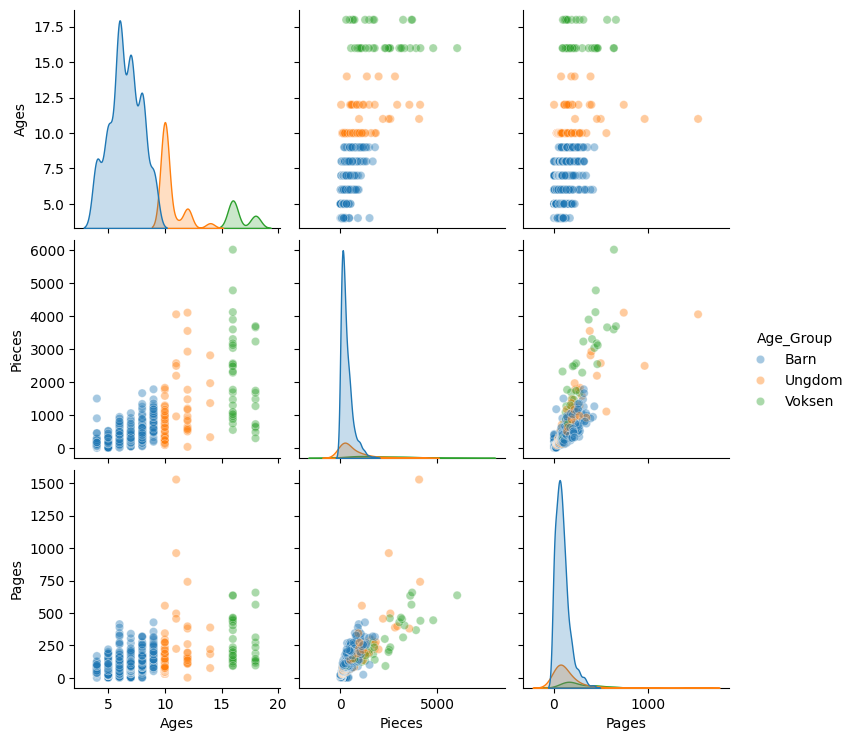

In [178]:
df3 = df2

def calc_age_group(row):
    if row['Ages'] < 10:
        return 'Barn'
    if row['Ages'] >= 10 and row['Ages'] < 15:
        return 'Ungdom'
    if row['Ages'] >= 15:
        return 'Voksen'

df3 = df3.assign(Age_Group=df3.apply(calc_age_group, axis=1))

sns.pairplot(df3, vars = ['Ages', 'Pieces', 'Pages'],
             hue = 'Age_Group',
             diag_kind = 'kde',
             plot_kws = dict(alpha = 0.3))

In [ ]:
# enkel lineær regresjon, tar ikke hensyn til tema
res_sub = smf.ols('Price ~ Pieces' , data = barn).fit()

In [ ]:
# enkel LR for hvert tema hver for seg
resultater = []
for i, theme in enumerate(mythemes):
    modell3 = smf.ols('Price ~ Pieces' , data = barn[barn['Theme'].isin([theme])])
    resultater.append(modell3.fit())

In [ ]:
# plott av dataene og regresjonslinjene
for i, theme in enumerate(mythemes):
    slope = resultater[i].params['Pieces']
    intercept = resultater[i].params['Intercept']

    regression_x = np.array(barn[barn['Theme'].isin([theme])]['Pieces'])
    regression_y = slope * regression_x + intercept

    # Plot scatter plot and regression line
    plt.scatter(barn[barn['Theme'].isin([theme])]['Pieces'], barn[barn['Theme'].isin([theme])]['Price'], color=plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=theme)
    
plt.xlabel('Antall brikker')
plt.ylabel('Pris')
plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()

## 

In [ ]:
# multippel lineær regresjon
modell3_mlr = smf.ols('Price ~ Pieces + Theme' , data = barn)
modell3_mlr.fit().summary()

In [ ]:
# multippel lineær regresjon med en annen referansekategori
modell3_mlr_alt = smf.ols('Price ~ Pieces + C(Theme, Treatment("Star Wars"))' , data = barn)
modell3_mlr_alt.fit().summary()

In [ ]:
# plott
intercept = [modell3_mlr.fit().params['Theme[T.Star Wars]'], modell3_mlr.fit().params['Theme[T.NINJAGO]'], 0] + modell3_mlr.fit().params['Intercept']
slope = modell3_mlr.fit().params['Pieces']

for i, theme in enumerate(mythemes):

    regression_x = np.array(barn[barn['Theme'].isin([theme])]['Pieces'])
    regression_y = slope * regression_x + intercept[i]

    # Plot scatter plot and regression line
    plt.scatter(barn[barn['Theme'].isin([theme])]['Pieces'], barn[barn['Theme'].isin([theme])]['Price'], color = plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=theme)
    
# uten tema som forklaringsvariabel:
regression_x = np.array(barn['Pieces'])
regression_y = res_sub.params['Pieces'] * regression_x + res_sub.params['Intercept']
plt.plot(regression_x, regression_y, color='black', label = 'No theme')
    
plt.xlabel('Antall brikker')
plt.ylabel('Pris')
plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# med interaksjonsledd mellom antall brikker og tema
modell3_mlri = smf.ols('Price ~ Pieces*Theme' , data = barn)
modell3_mlri.fit().summary()

In [ ]:
# plott
intercept = [modell3_mlri.fit().params['Theme[T.Star Wars]'], modell3_mlri.fit().params['Theme[T.NINJAGO]'], 0] + modell3_mlri.fit().params['Intercept']
slope = [modell3_mlri.fit().params['Pieces:Theme[T.Star Wars]'], modell3_mlri.fit().params['Pieces:Theme[T.NINJAGO]'], 0] + modell3_mlri.fit().params['Pieces']

for i, theme in enumerate(mythemes):

    regression_x = np.array(barn[barn['Theme'].isin([theme])]['Pieces'])
    regression_y = slope[i] * regression_x + intercept[i]

    # Plot scatter plot and regression line
    plt.scatter(barn[barn['Theme'].isin([theme])]['Pieces'], barn[barn['Theme'].isin([theme])]['Price'], color=plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=theme)
    
# uten tema som forklaringsvariabel:
regression_x = np.array(barn['Pieces'])
regression_y = res_sub.params['Pieces'] * regression_x + res_sub.params['Intercept']
plt.plot(regression_x, regression_y, color='black', label='Theme unaccounted for')
    
plt.xlabel('Antall brikker')
plt.ylabel('Pris [$]')
plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()

NameError: name 'modell3_mlri' is not defined

In [ ]:
# Kode for å lagre plot som (.png)
## fjern 'plt.show()' og erstatt med:
# plt.savefig('my_plot.png')

In [ ]:
# Steg 5: Evaluere om modellen passer til dataene
# Plotte predikert verdi mot residual
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = modell3_mlri.fit().fittedvalues, y = modell3_mlri.fit().resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")

# Lage kvantil-kvantil-plott for residualene
sm.qqplot(modell3_mlri.fit().resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")
plt.show()

In [ ]:
# Gruppere temaer i nye grupper:
# (Harry Potter, NINJAGO og Star Wars havner i én gruppe, City og Friends i en annen, og alle andre i en tredje)
df2['cat'] = np.where(df2['Theme'].isin(['Harry Potter', 'NINJAGO', 'Star Wars']), 'Cat1', 
                      np.where(df2['Theme'].isin(['City', 'Friends']), 'Cat2', 'Cat3'))
df2.groupby(['cat']).size().reset_index(name = 'Count')

In [ ]:
df2.groupby(['cat', 'Theme']).size().reset_index(name = 'Count')